## Notebook containing the code for the paper Uncovering the Role of Non-Recorded Data in Distinguishing Autism Spectrum Disorder: Insights from the Distribution of Non-Recorded Data

**Author:** [Pedro Brandão Belisário](pedrobelisario1997@gmail.com), Natalia Cosse Batista, Annelise Julio-Costa, Rogério Gomes, Bruno André Santos

### Abstract

**Purpose:** Non-recorded data in autism spectrum disorder (ASD) eye-tracking studies have been consistently employed for eliminating outliers and subsequently either discarded or replaced. This research aims to investigate the role of non-recorded data as an indicator of ASD.

**Methods:** The dataset, sourced from [Nakano et al (2010)](https://doi.org/10.1098/rspb.2010.0587), included 50 children and 54 adults, evenly distributed between ASD and typical development groups. The dataset was simplified to discern moments when gaze positions could or couldn’t be recorded. Subsequently, a statistical analysis compared the distribution of non-records within each group. Multiple Support Vector Machines (SVMs) were then constructed with the primary goal of classifying both age groups based solely on the non-record distribution.

**Results:** The distribution of non-records proves to be a valuable feature for detecting ASD in children. The SVM model achieved an impressive 94% accuracy, and the p-value for the non-records distribution was a mere 0.0002. Conversely, this distinction is less conspicuous in adults. The confidence intervals for SVM models in the adult group suggest that alternative feature selection and classification methods might improve performance, particularly considering the p-value
of 0.2696 in their non-records distribution.

**Conclusion:** Non-recorded data, albeit overlooked in eye-tracking research, is a valuable tool for identifying autistic children. While it effectively differentiates ASD from typical development in children, this distinction weakens with age, particularly among individuals with high IQs. This research highlights the importance of recognizing non-records as a crucial feature in ASD studies and emphasizes the need for further investigation into the underlying reasons behind non-records

----------------------------------------------------

# Code
### Libraries

In [1]:
import scipy
import scipy.io
import cv2

import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch import Tensor
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.feature_selection import f_classif
from sklearn.metrics import confusion_matrix

import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

### Use CUDA?

In [2]:
# Check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
    torch.set_default_tensor_type('torch.FloatTensor')
else:
    print('CUDA is available!  Training on GPU ...')
    torch.set_default_tensor_type('torch.cuda.FloatTensor')

CUDA is available!  Training on GPU ...


## Functions

In [3]:
def calcula_media_sigma_individuais(grupo: pd.DataFrame) -> np.array:
    '''
    Calculate each row the mean and sigma (standard deviation) return an ordened vector by its means
    
    Parameter
    ----------
    grupo: `Pandas Dataframe`
    
    '''
    vetor = []
    for _, msd in grupo.iterrows():
        vetor.append([np.mean(msd), np.std(msd, ddof=1)]);
    return np.sort(vetor, axis=0)

In [4]:
def curtose(grupo: np.array) -> float:
    '''
    Caculate the Kurtosis of each distribution
    
    Parameter
    ----------
    grupo: `numpy.array`
    
    '''
    media = grupo.mean()
    std = grupo.std()
    n = len(grupo)
    m4 = 0
    for elemento in grupo:
        m4 += (elemento - media)**4
    m4 = m4/(n*(std**4))
    return m4

In [5]:
# Box plots, shaded by density curves, 
# illustrate the distributions of non-records at the end of the visual stimulus for each of the examined groups
def boxplotDensityCorrCoef(cC: np.array, cA:np.array, aC:np.array, aA: np.array) -> None:
    '''
    Print the boxplot shadowed by the violin plot of all groups
    
    Parameters
    ----------
    cC: `numpy.array` -> The mean of non-recorded data for each participant in the children control group.
    cA: `numpy.array` -> The mean of non-recorded data for each participant in the children autistic group.
    aC: `numpy.array` -> The mean of non-recorded data for each participant in the adult control group.
    aA: `numpy.array` -> The mean of non-recorded data for each participant in the adult autistic group.
    
    '''
    # Agroup the parameters
    data = [cC, cA, aC, aA]
    
    # Generate the violion plot of each group
    parts = plt.violinplot(data, showmeans=False, showextrema=False)
    # Recolor the density curves as silver with a transparence of 50%
    for part in parts['bodies']:
        part.set_facecolor('silver')
        part.set_alpha(0.5)
    
    # Label them as Density
    parts['bodies'][-1].set_label('Density')
    
    # Control Children BoxPlot
    bp = plt.boxplot(cC, showmeans=True, positions = [1], 
                     labels=['Control\nChildren'], patch_artist=True,
                     meanprops={'marker':'.', 'markerfacecolor':'black', 'markeredgecolor':'black'},
                     medianprops={'color':'black', 'linestyle':'--'}, 
                     boxprops={'color':'black', 'facecolor':'blue'})
    
    # Control Children Quartiles
    quartiles = np.array([bp['whiskers'][0].get_data()[1][0],   # Q1
                          bp['whiskers'][0].get_data()[1][1],   # Q2
                          bp['medians'][0].get_data()[1][1],    # Median
                          bp['whiskers'][1].get_data()[1][0],   # Q3
                          bp['whiskers'][1].get_data()[1][1],   # Q4
                          bp['fliers'][0].get_data()[1][0]])    # Outlier
    
    plt.hlines(quartiles, [0.7] * quartiles.size, [1]*quartiles.size, 
               color='k', linestyle=':', linewidth=0.7, zorder=0)
    
    # Write Q1
    plt.annotate(f'{100*quartiles[0]:.2f}%', 
                 xy=(0.7, quartiles[0]),
                 xytext=(0.5, quartiles[0]))
    # Write Q2
    plt.annotate(f'{100*quartiles[1]:.2f}%', 
                 xy=(0.7, quartiles[1]),
                 xytext=(0.5, quartiles[1]))
    # Write Median
    plt.annotate(f'{100*quartiles[2]:.2f}%', 
                 xy=(0.7, quartiles[2]),
                 xytext=(0.5, quartiles[2]))
    
    # Write Q3
    plt.annotate(f'{100*quartiles[3]:.2f}%', 
                 xy=(0.7, quartiles[3]),
                 xytext=(0.5, quartiles[3]))
    
    # Write Q4
    plt.annotate(f'{100*quartiles[4]:.2f}%', 
                 xy=(0.7, quartiles[4]),
                 xytext=(0.5, quartiles[4]))
    
    # Write Outlier
    plt.annotate(f'{100*quartiles[5]:.2f}%', 
                 xy=(0.7, quartiles[5]),
                 xytext=(0.5, quartiles[5]))
    
    # Autistic Children Quartiles
    bp = plt.boxplot(cA, showmeans=True, positions= [2],
                     labels=['Autistic\nChildren'], patch_artist=True, 
                     meanprops={'marker':'.', 'markerfacecolor':'black', 'markeredgecolor':'black'},
                     medianprops={'color':'black', 'linestyle':'--'}, 
                     boxprops={'color':'black', 'facecolor':'red'})
    
    # Autistic Children Quartiles
    quartiles = np.array([bp['whiskers'][0].get_data()[1][0],   # Q1
                          bp['whiskers'][0].get_data()[1][1],   # Q2
                          bp['medians'][0].get_data()[1][1],    # Median
                          bp['whiskers'][1].get_data()[1][0],   # Q3
                          bp['whiskers'][1].get_data()[1][1]])  # Q4
    
    plt.hlines(quartiles, [1.7] * quartiles.size, [2]*quartiles.size, 
               color='k', linestyle=':', linewidth=0.7, zorder=0)
    
    # Write Q1
    plt.annotate(f'{100*quartiles[0]:.2f}%', 
                 xy=(1.7, quartiles[0]),
                 xytext=(1.5, quartiles[0]))
    # Write Q2
    plt.annotate(f'{100*quartiles[1]:.2f}%', 
                 xy=(1.7, quartiles[1]),
                 xytext=(1.5, quartiles[1]))
    # Write Median
    plt.annotate(f'{100*quartiles[2]:.2f}%', 
                 xy=(1.7, quartiles[2]),
                 xytext=(1.5, quartiles[2]))
    
    # Write Q3
    plt.annotate(f'{100*quartiles[3]:.2f}%', 
                 xy=(1.7, quartiles[3]),
                 xytext=(1.5, quartiles[3]))
    
    # Write Q4
    plt.annotate(f'{100*quartiles[4]:.2f}%', 
                 xy=(1.7, quartiles[4]),
                 xytext=(1.5, quartiles[4]))
    
    # Control Adults Boxplot
    bp = plt.boxplot(aC, showmeans=True, positions = [3],
                     labels=['Control\nAdults'], patch_artist=True,
                     meanprops={'marker':'.', 'markerfacecolor':'black', 'markeredgecolor':'black'},
                     medianprops={'color':'black', 'linestyle':'--'}, 
                     boxprops={'color':'black', 'facecolor':'blue'})
    
    # Control Adults Quartiles
    quartiles = np.array([bp['whiskers'][0].get_data()[1][0],   # Q1
                          bp['whiskers'][0].get_data()[1][1],   # Q2
                          bp['medians'][0].get_data()[1][1],    # Median
                          bp['whiskers'][1].get_data()[1][0],   # Q3
                          bp['whiskers'][1].get_data()[1][1]])  # Q4
    
    plt.hlines(quartiles, [2.7] * quartiles.size, [3]*quartiles.size, 
               color='k', linestyle=':', linewidth=0.7, zorder=0)
    
    # Write Q1
    plt.annotate(f'{100*quartiles[0]:.2f}%', 
                 xy=(2.7, quartiles[0]),
                 xytext=(2.5, quartiles[0]))
    # Write Q2
    plt.annotate(f'{100*quartiles[1]:.2f}%', 
                 xy=(2.7, quartiles[1]),
                 xytext=(2.5, quartiles[1]))
    # Write Median
    plt.annotate(f'{100*quartiles[2]:.2f}%', 
                 xy=(2.7, quartiles[2]),
                 xytext=(2.5, quartiles[2]))
    
    # Write Q3
    plt.annotate(f'{100*quartiles[3]:.2f}%', 
                 xy=(2.7, quartiles[3]),
                 xytext=(2.5, quartiles[3]))
    
    # Write Q4
    plt.annotate(f'{100*quartiles[4]:.2f}%', 
                 xy=(2.7, quartiles[4]),
                 xytext=(2.5, quartiles[4]))
    
    # Autistic Adults Boxplot
    bp = plt.boxplot(aA, showmeans=True, positions= [4],
                     labels=['Autistic\nAdults'], patch_artist=True,
                     meanprops={'marker':'.', 'markerfacecolor':'black', 'markeredgecolor':'black', 'label':'Mean'},
                     medianprops={'color':'black', 'linestyle':'--', 'label':'Median'}, 
                     boxprops={'color':'black', 'facecolor':'red'}, 
                     flierprops={'label':'Outliers'})
    
    # Autistic Adults Quartiles + Outlier
    quartiles = np.array([bp['whiskers'][0].get_data()[1][0],   # Q1
                          bp['whiskers'][0].get_data()[1][1],   # Q2
                          bp['medians'][0].get_data()[1][1],    # Median
                          bp['whiskers'][1].get_data()[1][0],   # Q3
                          bp['whiskers'][1].get_data()[1][1],   # Q4
                          bp['fliers'][0].get_data()[1][1]])    # Outlier
    
    plt.hlines(quartiles, [3.7] * quartiles.size, [4]*quartiles.size, 
               color='k', linestyle=':', linewidth=0.7, zorder=0)
    
    # Write Q1
    plt.annotate(f'{100*quartiles[0]:.2f}%', 
                 xy=(3.7, quartiles[0]),
                 xytext=(3.5, quartiles[0]))
    # Write Q2
    plt.annotate(f'{100*quartiles[1]:.2f}%', 
                 xy=(3.7, quartiles[1]),
                 xytext=(3.5, quartiles[1]))
    # Write Median
    plt.annotate(f'{100*quartiles[2]:.2f}%', 
                 xy=(3.7, quartiles[2]),
                 xytext=(3.5, quartiles[2]))
    
    # Write Q3
    plt.annotate(f'{100*quartiles[3]:.2f}%', 
                 xy=(3.7, quartiles[3]),
                 xytext=(3.5, quartiles[3]))
    
    # Write Q4
    plt.annotate(f'{100*quartiles[4]:.2f}%', 
                 xy=(3.7, quartiles[4]),
                 xytext=(3.5, quartiles[4]))
    # Write Outlier
    plt.annotate(f'{100*quartiles[5]:.2f}%', 
                 xy=(3.7, quartiles[5]),
                 xytext=(3.5, quartiles[5]))
    
    plt.xlim(left=0.3)
    plt.tick_params(left = False, labelleft = False)
    plt.legend(loc='best', ncols=2)
    plt.savefig(f'Imagem/BoxplotComparandoOpercentualDePerda', dpi=500)
    plt.show()
    cCcAtTest = scipy.stats.ttest_ind(cC, cA, equal_var=False, 
                                      random_state=0, alternative='two-sided')
    aCaAtTest = scipy.stats.ttest_ind(aC, aA, equal_var=False, 
                                      random_state=0, alternative='two-sided')
    cCaAtTest = scipy.stats.ttest_ind(cC, aA, equal_var=False, 
                                      random_state=0, alternative='two-sided')
    aCcAtTest = scipy.stats.ttest_ind(cA, aC, equal_var=False, 
                                      random_state=0, alternative='two-sided')
    aCcCtTest = scipy.stats.ttest_ind(aC, cC, equal_var=False, 
                                      random_state=0, alternative='two-sided')
    
    print('Kurtosis - Evaluate Skewness')
    print(f"Curtose - Criança controle: {curtose(cC)}")
    print(f"Curtose - Criança TEA: {curtose(cA)}")
    print(f"Curtose - Adultos controle: {curtose(aC)}")
    print(f"Curtose - Adultos TEA: {curtose(aA)}")
    print()
    print('Pearson correlation coefficient (p-value)')
    print(f"Crianças Controle X Crianças TEA: {cCcAtTest.pvalue:.4f}")
    print(f"Crianças Controle X Adultos  TEA: {cCaAtTest.pvalue:.4f}")
    print(f"Adultos  Controle X Adultos  TEA: {aCaAtTest.pvalue:.4f}")
    print(f"Adultos  Controle X Crianças TEA: {aCcAtTest.pvalue:.4f}")
    print(f"Adultos  Controle X Crianças Controle: {aCcCtTest.pvalue:.4f}")

In [6]:
def percentage_loss_mean_timeskip(controle: pd.DataFrame, autista: pd.DataFrame, grupo: str) -> None:
    '''
    Print the percentage of non-record
    
    Parameters
    ----------
    controle: `Pandas DataFrame` -> Control  group adjusted dataset
    autista: `Pandas DataFrame`  -> Autistic group adjusted dataset
    grupo:   `str`               -> Which age group is being processed
    
    '''
    # Calculate the percentage of non-recorded data at a given timestamp
    psum_C = controle.mean().cumsum()/np.arange(1, controle.shape[1]+1) * 100
    psum_A = autista.mean().cumsum()/np.arange(1, autista.shape[1]+1)   * 100
    
    
    # plot each group curve
    plt.plot(psum_C, color='blue', label='Control Group')
    plt.plot(psum_A, color='red', label='Autistic Group')
    plt.grid()
    
    # If it is the children group
    if grupo == 'Crianças':
        min_x = 1284
        max_x = psum_A.iloc[1285:].idxmin()
        # Draw a green box with circles (Transparence 20%)
        plt.axvspan(xmin = min_x, xmax = 2000, ymin = 0.455, ymax=0.68, 
                    alpha = 0.2, color = 'green', hatch= ".oO")        
        plt.plot([1284, 2000], [20, 20], '.:', color='green')
        plt.plot([2000, 2000], [20, 27.2], '.:', color='green')
        plt.plot([2000, 1284], [27.2, 27.2], '.:', color='green')
        plt.plot([1284, 1284], [27.2, 20], '.:', color='green')
        
        # Draw a checkred yellow box (Transparence 20%)
        plt.axvspan(xmin = 2000, xmax = 2850, ymin = 0.455, ymax=0.68, 
                    alpha = 0.2, facecolor = 'yellow', edgecolor='orange', hatch= "++")
        plt.plot([2010, 2850], [20, 20], '+--', color='orange')
        plt.plot([2850, 2850], [20, 27.2], '+--', color='orange')
        plt.plot([2850, 2010], [27.2, 27.2], '+--', color='orange')
        plt.plot([2010, 2010], [27.2, 20], '+--', color='orange')
        
        # Line marking the beginning of stability
        plt.axvline(x=600, ymax=0.3, ls=':', color='black')
    else:
        # Line marking the beginning of stability
        plt.axvline(x=1160, ymax=0.465, ls=':', color='black')
    
    plt.legend()
    plt.ylabel('Percentage of non-recorded data')
    plt.xlabel(r'$\it{timestamp}$')
    #plt.title(f'{grupo} - Porcentagem da media frames perdidos')
    plt.savefig(f'Imagem/{grupo}/{grupo}_Porcentagem da media frames perdidos.png', dpi=500)
    plt.show()

###### Classification

In [7]:
# Standarlization
padronizacao = lambda linha: ((linha - np.mean(linha))/np.std(linha))
# Convert Str to Float
convercaoStr2Float = lambda x: x.apply(lambda x: list(map(float, x.split(','))))

# Calculate the Student T-Test
def student_ttest (A_media: pd.Series, A_var: pd.Series, A_tam: int, 
                   C_media: pd.Series, C_var: pd.Series, C_tam: int) -> float:
    '''
    Calculate the T-value of 2 populations with equal means and unknown standard deviations
    
                         |A_media - C_media|
    t-value = -------------------------------------
               sqrt[(A_var/A_tam) + (C_var/C_tam)]
    
    Parameters
    ----------
    A_media: `pandas.Series` -> Mean of each Feature in the autistic group
    A_var  : `pandas.Series` -> Variance of each Feature in the autistic group
    A_tam  : `int`           -> number of elements in the autistic group
    C_media: `pandas.Series` -> Mean of each Feature in the control  group
    C_var  : `pandas.Series` -> Variance of each Feature in the control group
    C_tam  : `int`           -> number of elements in the control group
    
    '''
    denominador = np.sqrt((A_var/A_tam) + (C_var/C_tam))
    numerador = abs(A_media - C_media)
    return numerador/denominador

# Calculate Kappa Score - NOT USED
def kappa_score (y_true, y_pred) -> float:
    '''
    Caculate the kappa Score
    
                                 2 * [(T_positive * T_negative) - (F_negative * F_positive)]
    k = -----------------------------------------------------------------------------------------------------------------
        [(T_positive + F_positive) * (F_positive + T_negative)] + [(T_positive + F_negative) * (F_negative + T_negative)]
        
    Parameters
    ----------
    y_true: `numpy.array` -> Correct Vector
    y_pred: `numpy.array` -> Prediction Vector
    
    '''
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    num = 2* ((tp*tn) - (fn*fp))
    dem = (tp+fp) * (fp+tn) + (tp+fn) * (fn+tn)
    return num/dem
    
def model_SVM(controle: pd.DataFrame, autista: pd.DataFrame, test_sz:float, grupo:str) -> pd.DataFrame:
    try:
        print(f'{grupo} - Lendo arquivos...')
        resultados = pd.read_csv(f'{grupo}_resultados.csv', sep=',', index_col=0)
        resultados.loc['Previsao':] = resultados.loc['Previsao':].apply(convercaoStr2Float)
        resultados.loc['Gabarito'] = resultados.loc['Gabarito'].apply(lambda x: list(map(float, x.split(','))))
        return resultados
    except IOError:
        print('Files not Found...\nTraining process...')
        conjuntos = {'Todas Features': np.ndarray(shape=(4, 1), dtype=np.ndarray), 
                     'T Test'        : np.ndarray(shape=(4, 1), dtype=np.ndarray), 
                     'Var'           : np.ndarray(shape=(4, 1), dtype=np.ndarray),
                     'Anova'         : np.ndarray(shape=(4, 1), dtype=np.ndarray)}
        # Pos 1 - Best model mean
        # Pos 2 - Best model std
        # Pos 3 - Answers
        # Pos 4 - Prevision

        # Number of Features
        f_num = 77

        # GridSearch Parameters
        grid_parameters = {'kernel': ['rbf'], 
                           'gamma': [float(f'2e{f}') for f in np.arange(-7, 7)], 
                           'C': [float(f'2e{f}') for f in np.arange(-7, 7)]}

        # Train/Test separation
        participantes = pd.concat([controle, autista], ignore_index=True)
        gabarito = np.append(np.zeros(len(controle)), np.ones(len(autista)))
        X_treino, X_teste, Y_treino, Y_teste = train_test_split(participantes, gabarito,
                                                                test_size=test_sz,stratify=gabarito, 
                                                                random_state=1152)
        print('Training vanila model...')
        # Classifier without Feature Selection
        clf_completo = GridSearchCV(SVC(), grid_parameters, scoring='f1', cv=10, n_jobs=-1, verbose=3)
        clf_completo.fit(X_treino, Y_treino)
        # Best Model
        conjuntos['Todas Features'][0] = str(clf_completo.cv_results_['mean_test_score'][clf_completo.best_index_])
        conjuntos['Todas Features'][1] = str(clf_completo.cv_results_['std_test_score'][clf_completo.best_index_])
        # Prediction
        conjuntos['Todas Features'][2] = ','.join(f'{num}' for num in Y_teste)
        conjuntos['Todas Features'][3] = ','.join(f'{num}' for num in clf_completo.predict(X_teste))

        print('Training Student T-test model...')
        # Classifier with Student t-test as feature selector
        # Base stardatizion
        padronizado = X_treino.apply(padronizacao, axis=0)
        # Apply the Student T-Test on the features and Ranks them
        A_var = padronizado[Y_treino==1].var(axis=0)
        A_med = padronizado[Y_treino==1].mean(axis=0)
        A_tam = padronizado[Y_treino==1].count(axis=0)[0]
        C_var = padronizado[Y_treino==0].var(axis=0)
        C_med = padronizado[Y_treino==0].mean(axis=0)
        C_tam = padronizado[Y_treino==0].count(axis=0)[0]
        t_val = student_ttest(A_med,A_var, A_tam, C_med, C_var, C_tam).dropna().sort_values(ascending=False)
        # Select the 77 best
        indexes = t_val.iloc[:f_num].index
        # Classifier
        clf_ttest = GridSearchCV(SVC(), grid_parameters, scoring='f1', cv=10, n_jobs=-1, verbose=3)
        clf_ttest.fit(X_treino[indexes], Y_treino)
        conjuntos['T Test'][0] = str(clf_ttest.cv_results_['mean_test_score'][clf_ttest.best_index_])
        conjuntos['T Test'][1] = str(clf_ttest.cv_results_['std_test_score'][clf_ttest.best_index_])
        # Prediction
        conjuntos['T Test'][2] = ','.join(f'{num}' for num in Y_teste)
        conjuntos['T Test'][3] = ','.join(f'{num}' for num in clf_ttest.predict(X_teste[indexes]))

        print('Training Variance model...')
        # Classifier with Variance as feature selector
        # Calculate the variance of each feature group and rank them
        variancia = X_treino.apply(pd.DataFrame.var, axis=0).sort_values(ascending=False)
        # Select the 77 best
        var_indexes = variancia.iloc[:f_num].index
        # Classifier
        clf_var = GridSearchCV(SVC(), grid_parameters, scoring='f1', cv=10, n_jobs=-1, verbose=3)
        clf_var.fit(X_treino[var_indexes], Y_treino)
        conjuntos['Var'][0] = str(clf_var.cv_results_['mean_test_score'][clf_var.best_index_])
        conjuntos['Var'][1] = str(clf_var.cv_results_['std_test_score'][clf_var.best_index_])
        # Prediction
        conjuntos['Var'][2] = ','.join(f'{num}' for num in Y_teste)
        conjuntos['Var'][3] = ','.join(f'{num}' for num in clf_var.predict(X_teste[var_indexes]))

        print('Training ANOVA model...')
        # Classifier with ANOVA as feature selector
        # ANOVA
        _, p = f_classif(X_treino, Y_treino)
        p = pd.Series(p).dropna().sort_values(ascending=False)
        # Select the 77 best
        anova_indexes = p.iloc[:f_num].index
        # Classifier
        clf_anova = GridSearchCV(SVC(), grid_parameters, scoring='f1', cv=10, n_jobs=-1, verbose=3)
        clf_anova.fit(X_treino[anova_indexes], Y_treino)
        conjuntos['Anova'][0] = str(clf_anova.cv_results_['mean_test_score'][clf_anova.best_index_])
        conjuntos['Anova'][1] = str(clf_anova.cv_results_['std_test_score'][clf_anova.best_index_])
        # Prediction
        conjuntos['Anova'][2] = ','.join(f'{num}' for num in Y_teste)
        conjuntos['Anova'][3] = ','.join(f'{num}' for num in clf_anova.predict(X_teste[anova_indexes]))

        # Escrita de Arquivo
        col_names = ['Media Teste', 'Std Teste', 'Gabarito', 'Previsao']

        print('Saving a new File...')
        resultados = pd.DataFrame(np.concatenate((conjuntos['Todas Features'].T, 
                                                    conjuntos['T Test'].T,
                                                    conjuntos['Var'].T,
                                                    conjuntos['Anova'].T)), 
                                    index = ['Todas Features', 'T Test', 'Variancia', 'Anova'], 
                                    columns = col_names)
        resultados = resultados.T
        resultados.to_csv(f'{grupo}_resultados.csv', sep=',', index=True)
        resultados.loc['Previsao':] = resultados.loc['Previsao':].apply(convercaoStr2Float)
        resultados.loc['Gabarito'] = resultados.loc['Gabarito'].apply(lambda x: list(map(float, x.split(','))))
        print('Done !')
        print()
        return resultados

In [8]:
def exact_interval(prob:float, confianca:float, n:int)-> None:
    '''
    Calculate the exact binomial interval at alpha 0.05
    
    Adapted from: (Last access in 23/10/23)
    -------------
    https://www.itl.nist.gov/div898/handbook/prc/section2/prc241.htm
    https://www.itl.nist.gov/div898/handbook/prc/section2/prc241.r
    
    Parameters:
    -----------
    prob     : `float` -> Metric Probability
    confianca: `float` -> Desired confidence interval
    n        : `int`   -> Number of samples
    
    '''
    ajuste = 2 if (n == 35) or (n == 54-35) else 1
    Nd = round(prob*n)
    alpha2 = (1-confianca)/2
    if (Nd != 0):
        fl = lambda p: scipy.stats.binom.cdf(Nd-1,n,p) - (1-alpha2)
        i_lim = scipy.optimize.root_scalar(fl, bracket=[0.01, 0.99]).root
    else:
        i_lim = 0
        
    if (Nd != n) and (Nd != n-ajuste):
        fu = lambda p: scipy.stats.binom.cdf(Nd,n,p) - alpha2
        s_lim = scipy.optimize.root_scalar(fu, bracket=[0.01, 0.99]).root
    else:
        s_lim=1
    
    return f'Limite Inferior: {i_lim:.4f}, Superior: {s_lim:.4f}'
def print_metrica(score: float, gabarito: np.array, previsao: np.array, total) -> None:
    tp = np.sum((gabarito == 1) & (previsao == 1))
    tn = np.sum((gabarito == 0) & (previsao == 0))
    fn = np.sum((gabarito == 1) & (previsao == 0))
    fp = np.sum((gabarito == 0) & (previsao == 1))
    Acur = (tp+tn)/len(gabarito)
    PPV = (tp)/(tp+fp)
    NPV = 0 if tn+fn == 0 else(tn)/(tn+fn)
    TPR = (tp)/(tp+fn)
    TNR = (tn)/(tn+fp)
    F1S = 2*tp/(2*tp + fp + fn)
    CKS = (2* ((tp*tn) - (fn*fp))) / (((tp+fp) * (fp+tn)) + ((tp+fn) * (fn+tn)))
    print(f'Nota Dev :\t{score:.4f}\t{exact_interval(score, 0.95, total-len(gabarito))}', end='\n\t')
    print(f'Acur     :\t{Acur:.4f}\t{exact_interval(Acur, 0.95, len(gabarito))}', end='\n\t')
    print(f'PPV      :\t{PPV:.4f}\t{exact_interval(PPV, 0.95, len(gabarito))}', end='\n\t')
    print(f'NPV      :\t{NPV:.4f}\t{exact_interval(NPV, 0.95, len(gabarito))}', end='\n\t')
    print(f'TPR      :\t{TPR:.4f}\t{exact_interval(TPR, 0.95, len(gabarito))}', end='\n\t')
    print(f'TNR      :\t{TNR:.4f}\t{exact_interval(TNR, 0.95, len(gabarito))}', end='\n\t')
    print(f'F1S      :\t{F1S:.4f}\t{exact_interval(F1S, 0.95, len(gabarito))}', end='\n\t')
    #print(f'CKS      :\t{CKS:.4f}\t{exact_interval(CKS, 0.95, len(gabarito))}') 

## Load DataSet

In [9]:
# Carrega o arquivo .mat formato dicionário
mat = scipy.io.loadmat('../allclip1_n104.mat')

# Será utilizado somente as chaves 'gaze' e 'group_name_n104'
# A chave 'group_n104' corresponde ao código utilizado para a chave 'group_name_n104'
group = []
for row in mat['group_name_n104']:
    for col in row:
        group.append(col[0])
        
eyeclip = []
for row in mat['gaze']:
    for col in row:
        eyeclip.append(col)

data = pd.DataFrame(data={'eyeclip':eyeclip, 'group':group})

#### Adjusting the DataSet

- If the gaze position (Column <span style="color:Darkred">'eyeclip'</span>) were recorded change it to <span style="color:blue">0</span> otherwise to <span style="color:red">1</span>

In [10]:
# Adjusting Children
# Map Function 
# IF VALUE OF v IS nan THEN CHANGE IT TO 1
# OTHERWISE CHANGE IT TO 0

C_controle = pd.DataFrame()
for child in data[data['group'] == 'child control']['eyeclip']:
    c = [(map(lambda v: 1.0 if np.isnan(v) == True else 0.0, child[:, 0]))]
    C_controle = C_controle.append(c, ignore_index=True)


C_autista = pd.DataFrame()
for child in data[data['group'] == 'child autistic']['eyeclip']:
    a = [(map(lambda v: 1.0 if np.isnan(v) == True else 0.0, child[:, 0]))]
    C_autista = C_autista.append(a, ignore_index=True)

C:\Users\pedro\AppData\Local\Temp\ipykernel_25300\1529173524.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  C_controle = C_controle.append(c, ignore_index=True)
C:\Users\pedro\AppData\Local\Temp\ipykernel_25300\1529173524.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  C_autista = C_autista.append(a, ignore_index=True)


In [11]:
# Adjusting Adults
# Map Function 
# IF VALUE OF v IS nan THEN CHANGE IT TO 1
# OTHERWISE CHANGE IT TO 0

A_controle = pd.DataFrame()
for adult in data[data['group'] == 'adult control']['eyeclip']:
    # Mapeia True como 1 e False como 1
    a = [(map(lambda v: 1.0 if np.isnan(v) == True else 0.0, adult[:, 0]))]
    A_controle = A_controle.append(a, ignore_index=True)


A_autista = pd.DataFrame()
for adult in data[data['group'] == 'adult autistic']['eyeclip']:
    # Mapeia True como 1 e False como 1
    a = [(map(lambda v: 1.0 if np.isnan(v) == True else 0.0, adult[:, 0]))]
    A_autista = A_autista.append(a, ignore_index=True)

C:\Users\pedro\AppData\Local\Temp\ipykernel_25300\1418263955.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  A_controle = A_controle.append(a, ignore_index=True)
C:\Users\pedro\AppData\Local\Temp\ipykernel_25300\1418263955.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  A_autista = A_autista.append(a, ignore_index=True)


## Statistical Analysis

### BoxPlot

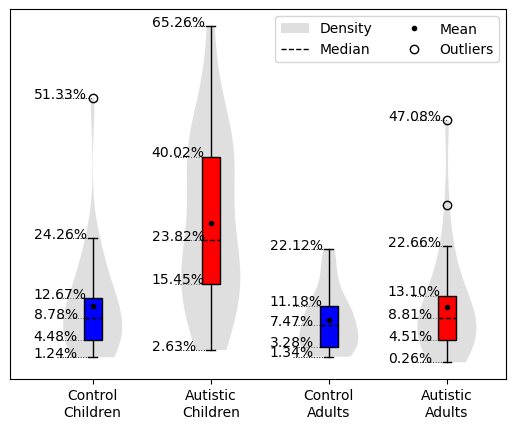

Kurtosis - Evaluate Skewness
Curtose - Criança controle: 9.27907782872232
Curtose - Criança TEA: 2.3539047672237836
Curtose - Adultos controle: 2.8442144756388408
Curtose - Adultos TEA: 7.104883508623962

Pearson correlation coefficient (p-value)
Crianças Controle X Crianças TEA: 0.0002
Crianças Controle X Adultos  TEA: 0.9772
Adultos  Controle X Adultos  TEA: 0.2696
Adultos  Controle X Crianças TEA: 0.0000
Adultos  Controle X Crianças Controle: 0.2837


In [12]:
Msd_crianca_C = calcula_media_sigma_individuais(C_controle)
Msd_crianca_A = calcula_media_sigma_individuais(C_autista)
Msd_adulto_C = calcula_media_sigma_individuais(A_controle)
Msd_adulto_A = calcula_media_sigma_individuais(A_autista)
boxplotDensityCorrCoef(Msd_crianca_C[:, 0], Msd_crianca_A[:, 0], Msd_adulto_C[:, 0], Msd_adulto_A[:, 0])

### Percentage of the non-recorded data per group

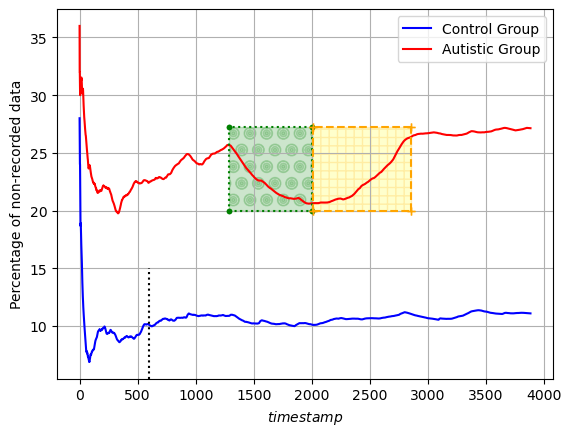

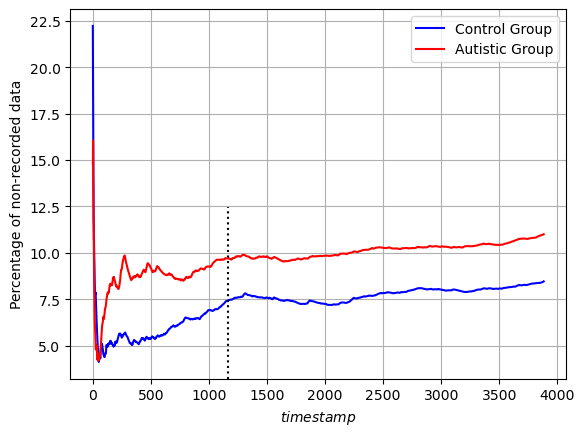

In [13]:
percentage_loss_mean_timeskip(C_controle, C_autista, 'Crianças')
percentage_loss_mean_timeskip(A_controle, A_autista, 'Adultos')

### SVM Classification

In [14]:
C_svm = model_SVM(C_controle, C_autista, 0.34, 'Children')
A_svm = model_SVM(A_controle, A_autista, 0.34, 'Adults')

print()
print('Children')
for i in C_svm.columns:
    print(i, end='\n\t')
    print_metrica(float(C_svm[i]['Media Teste']), np.array(C_svm[i]['Gabarito']), np.array(C_svm[i]['Previsao']), 50)
    print()
    
print('Adults')
for i in A_svm.columns:
    print(i, end='\n\t')
    print_metrica(float(A_svm[i]['Media Teste']), np.array(A_svm[i]['Gabarito']), np.array(A_svm[i]['Previsao']), 54)
    print()

Children - Lendo arquivos...
Adults - Lendo arquivos...

Children
Todas Features
	Nota Dev :	0.7433	Limite Inferior: 0.5774, Superior: 0.8891
	Acur     :	0.8235	Limite Inferior: 0.5657, Superior: 0.9620
	PPV      :	0.8571	Limite Inferior: 0.6356, Superior: 0.9854
	NPV      :	0.8000	Limite Inferior: 0.5657, Superior: 0.9620
	TPR      :	0.7500	Limite Inferior: 0.5010, Superior: 0.9319
	TNR      :	0.8889	Limite Inferior: 0.6356, Superior: 0.9854
	F1S      :	0.8000	Limite Inferior: 0.5657, Superior: 0.9620
	
T Test
	Nota Dev :	0.8400	Limite Inferior: 0.6810, Superior: 0.9489
	Acur     :	0.6471	Limite Inferior: 0.3833, Superior: 0.8579
	PPV      :	0.5714	Limite Inferior: 0.3292, Superior: 0.8156
	NPV      :	1.0000	Limite Inferior: 0.8049, Superior: 1.0000
	TPR      :	1.0000	Limite Inferior: 0.8049, Superior: 1.0000
	TNR      :	0.3333	Limite Inferior: 0.1421, Superior: 0.6167
	F1S      :	0.7273	Limite Inferior: 0.4404, Superior: 0.8969
	
Variancia
	Nota Dev :	0.7467	Limite Inferior: 0.5774, 